# ANALYSIS OF PM2.5 POLLUTION AND ITS IMPACT ON PUBLIC HEALTH: RACIAL AND NEIGHBORHOOD DISPARITIES IN NEW YORK CITY (2009-2022)

#### installing the required package

In [66]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [67]:
#loading in the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np  
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [68]:
#loading the datasets
cv_hospitalizations = pd.read_csv('NYC EH Data Portal - Cardiovascular hospitalizations due to PM2.5 (age 40) (filtered).csv')
resp_hospitalizations = pd.read_csv('NYC EH Data Portal - Respiratory hospitalizations due to PM2.5 (age 20+) (full table).csv')
asthma = pd.read_csv('NYC EH Data Portal - Asthma emergency department visits due to PM2.5 (full table).csv')
air_quality = pd.read_csv('Air_Quality.csv')

## Cleaning the data (Air Quality - main dataset)

In [69]:
# Check for missing values
print(air_quality.isnull().sum())

Unique ID             0
Indicator ID          0
Name                  0
Measure               0
Measure Info          0
Geo Type Name         0
Geo Join ID           9
Geo Place Name        9
Time Period           0
Start_Date            0
Data Value            0
Message           18025
dtype: int64


In [70]:
# Check for missing values
missing_values = air_quality.isnull().sum()
print(missing_values[missing_values > 0])  # Print only columns with missing values

# Drop rows with critical missing values 'Geo Place Name' and 'Data Value' are critical for your analysis
air_quality.dropna(subset=['Geo Place Name', 'Data Value'], inplace=True)

# For example, fill missing values in 'Geo Join ID' with a placeholder or drop those rows
air_quality['Geo Join ID'].fillna('Unknown', inplace=True)  # Example: filling with 'Unknown'

# Drop the 'Message' column 
air_quality.drop(columns=['Message'], inplace=True)

# Check the updated dataset for missing values again
print(air_quality.isnull().sum())

Geo Join ID           9
Geo Place Name        9
Message           18025
dtype: int64
Unique ID         0
Indicator ID      0
Name              0
Measure           0
Measure Info      0
Geo Type Name     0
Geo Join ID       0
Geo Place Name    0
Time Period       0
Start_Date        0
Data Value        0
dtype: int64


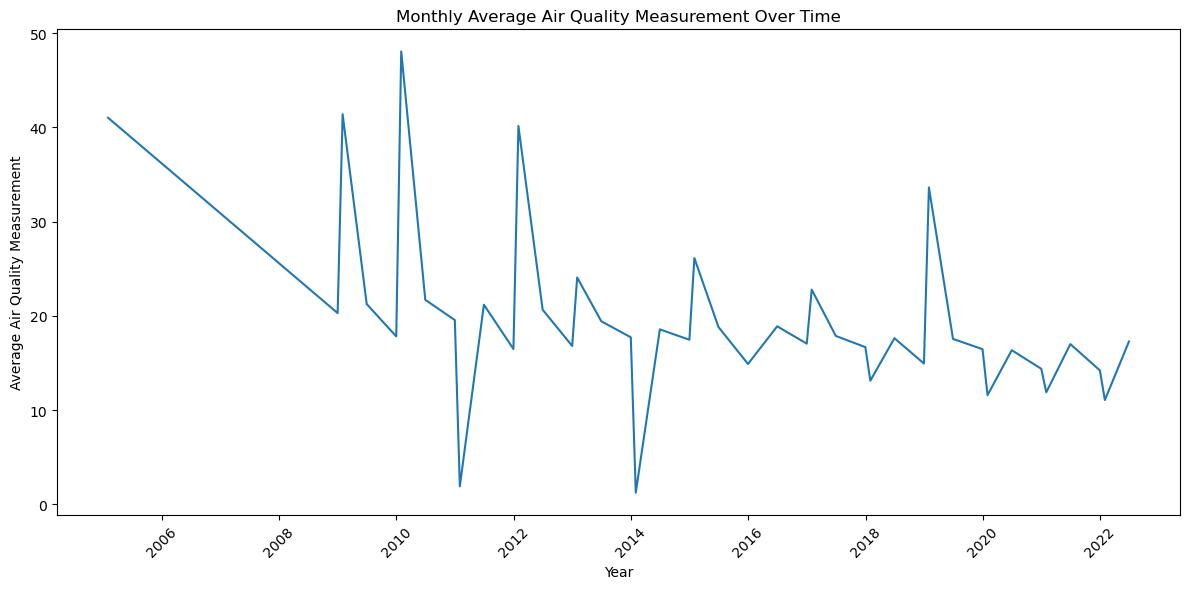

In [71]:
# Understand the trend of the air quality in the state of New York
air_quality['Start_Date'] = pd.to_datetime(air_quality['Start_Date'])

monthly_avg = air_quality.resample('M', on='Start_Date')['Data Value'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg, x='Start_Date', y='Data Value')
plt.title('Monthly Average Air Quality Measurement Over Time')
plt.xlabel('Year')
plt.ylabel('Average Air Quality Measurement')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [72]:
# Convert 'Start_Date' to datetime format
air_quality['Start_Date'] = pd.to_datetime(air_quality['Start_Date'], errors='coerce')

# Filter the dataset for the date range from 2009 to 2022
air_quality_filtered = air_quality[(air_quality['Start_Date'].dt.year >= 2009) & (air_quality['Start_Date'].dt.year <= 2022)]

# Check for missing values before cleaning
missing_values = air_quality_filtered.isnull().sum()
print("Missing values before cleaning:")
print(missing_values[missing_values > 0])  # Print only columns with missing values

# Drop rows with critical missing values (Geo Place Name and Data Value)
air_quality_filtered.dropna(subset=['Geo Place Name', 'Data Value'], inplace=True)

# Handle missing values in non-critical columns as needed (e.g., Geo Join ID)
air_quality_filtered.loc[:, 'Geo Join ID'] = air_quality_filtered['Geo Join ID'].fillna('Unknown')  # Example: filling with 'Unknown'

# Check the updated dataset for missing values
print("Missing values after cleaning:")
print(air_quality_filtered.isnull().sum())

# Check number of rows remain after the cleaning
print(f"Rows before cleaning: {air_quality.shape[0]}")
print(f"Rows after cleaning: {air_quality_filtered.shape[0]}")

Missing values before cleaning:
Series([], dtype: int64)
Missing values after cleaning:
Unique ID         0
Indicator ID      0
Name              0
Measure           0
Measure Info      0
Geo Type Name     0
Geo Join ID       0
Geo Place Name    0
Time Period       0
Start_Date        0
Data Value        0
dtype: int64
Rows before cleaning: 18016
Rows after cleaning: 16555


/tmp/ipykernel_637/182384222.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_quality_filtered.dropna(subset=['Geo Place Name', 'Data Value'], inplace=True)


In [73]:
# Load the geoJSON to plot maps in the later analysis
neighborhoods_name = gpd.read_file('Neighborhood Names GIS.geojson')
uhf34 = gpd.read_file('UHF34.geo.json')
uhf42 = gpd.read_file('UHF42.geo.json')
borough = gpd.read_file('neighborhood_two.geo.json')

In [74]:
# Display the first few rows to ensure it's loaded correctly --uhf34
print(uhf34.head())
print(uhf34.info())

   OBJECTID  UHF34_CODE BOROUGH                 UHF_NAME  UHF  \
0         1           0     Man                     None    0   
1         2         101   Bronx  Kingsbridge - Riverdale  101   
2         3         102   Bronx          Northeast Bronx  102   
3         4         103   Bronx     Fordham - Bronx Park  103   
4         5         104   Bronx     Pelham - Throgs Neck  104   

                                            geometry  
0  MULTIPOLYGON (((-73.76446 40.65449, -73.76098 ...  
1  POLYGON ((-73.87793 40.90556, -73.87859 40.903...  
2  POLYGON ((-73.81504 40.889, -73.81534 40.88678...  
3  POLYGON ((-73.85743 40.88104, -73.86095 40.874...  
4  MULTIPOLYGON (((-73.88366 40.82153, -73.88457 ...  
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    35 non-null     int32   
 1   UHF34_CODE  35 non-null     int32   
 

## Exploring the filtered air quality dataset

In [75]:
# Understand the data types and observing a few rows of the dataset
print(air_quality_filtered.info()) 
print(air_quality_filtered.head())

<class 'pandas.core.frame.DataFrame'>
Index: 16555 entries, 0 to 18023
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unique ID       16555 non-null  int64         
 1   Indicator ID    16555 non-null  int64         
 2   Name            16555 non-null  object        
 3   Measure         16555 non-null  object        
 4   Measure Info    16555 non-null  object        
 5   Geo Type Name   16555 non-null  object        
 6   Geo Join ID     16555 non-null  float64       
 7   Geo Place Name  16555 non-null  object        
 8   Time Period     16555 non-null  object        
 9   Start_Date      16555 non-null  datetime64[ns]
 10  Data Value      16555 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 1.5+ MB
None
   Unique ID  Indicator ID                                   Name  \
0     179772           640  Boiler Emissions- Total SO2 Emissions

In [76]:
# Descriptive statistics of numerical data
print(air_quality_filtered.describe())

           Unique ID  Indicator ID   Geo Join ID  \
count   16555.000000  16555.000000  1.655500e+04   
mean   450400.852915    425.325340  6.167729e+05   
min    121644.000000    365.000000  1.000000e+00   
25%    178472.500000    365.000000  2.020000e+02   
50%    412657.000000    375.000000  3.030000e+02   
75%    667105.500000    386.000000  4.040000e+02   
max    828353.000000    661.000000  1.051061e+08   
std    246918.272262    108.949737  7.938714e+06   

                          Start_Date    Data Value  
count                          16555  16555.000000  
mean   2015-05-26 21:28:44.216248576     20.389061  
min              2009-01-01 00:00:00      0.000000  
25%              2012-01-02 00:00:00      8.800000  
50%              2015-01-01 00:00:00     14.800000  
75%              2018-12-01 00:00:00     26.000000  
max              2022-06-01 00:00:00    299.400000  
std                              NaN     21.861361  


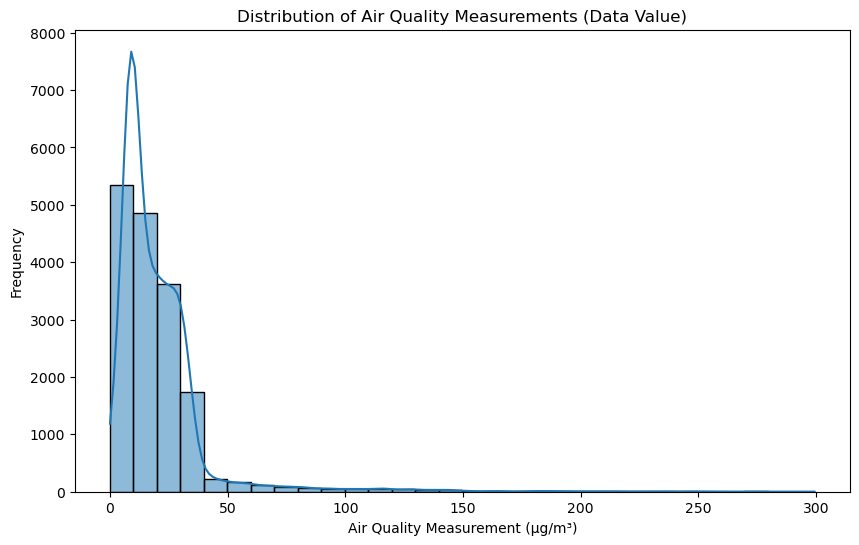

In [77]:
# Plot histogram to understand the data frequency of Air Quality Measurements
plt.figure(figsize=(10, 6))
sns.histplot(air_quality_filtered['Data Value'], bins=30, kde=True)
plt.title('Distribution of Air Quality Measurements (Data Value)')
plt.xlabel('Air Quality Measurement (µg/m³)')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_637/1012387965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_quality_filtered['Start_Date'] = pd.to_datetime(air_quality_filtered['Start_Date'])


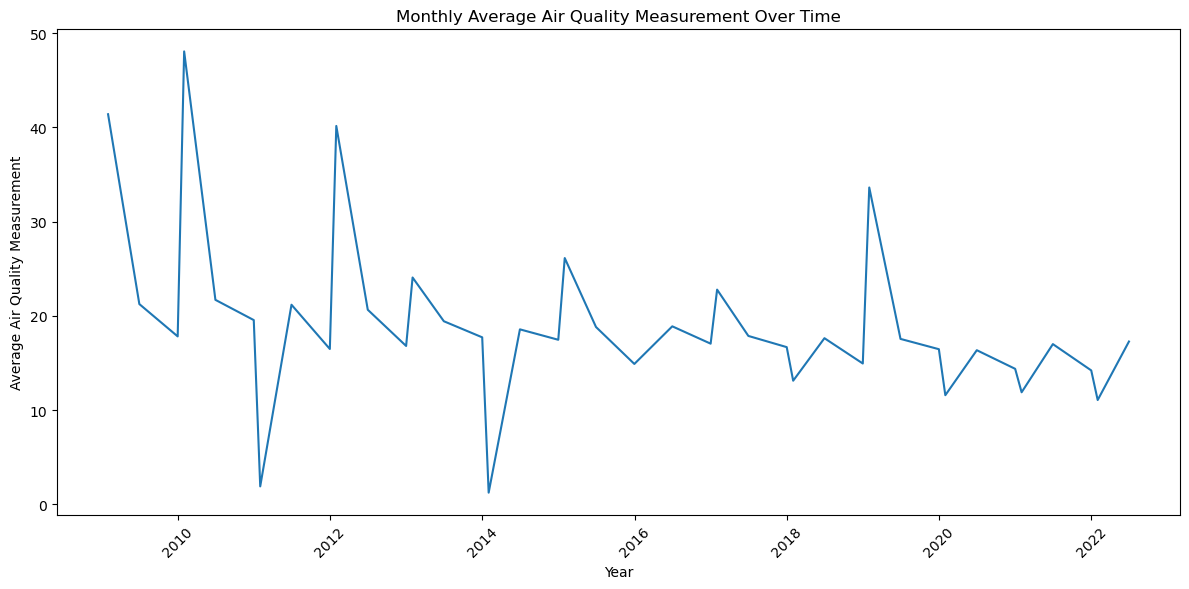

In [78]:
# Understand the trend of the air quality in the state of New York
air_quality_filtered['Start_Date'] = pd.to_datetime(air_quality_filtered['Start_Date'])

monthly_avg = air_quality_filtered.resample('M', on='Start_Date')['Data Value'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg, x='Start_Date', y='Data Value')
plt.title('Monthly Average Air Quality Measurement Over Time')
plt.xlabel('Year')
plt.ylabel('Average Air Quality Measurement')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data Analysis

### Objective - Composition identification based on the neighborhood and racial population air quality based on the NYC category segregation
### Hypothesis (H1) - Areas with a higher proportion of people of color have worse air quality (higher PM2.5 levels) compared to predominantly white neighborhoods.

/tmp/ipykernel_637/411398079.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Data Value', y='Name', data=geo_data, ax=axes[i], palette='muted', order=geo_data['Name'].unique())
/tmp/ipykernel_637/411398079.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Data Value', y='Name', data=geo_data, ax=axes[i], palette='muted', order=geo_data['Name'].unique())
/tmp/ipykernel_637/411398079.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Data Value', y='Name', data=geo_data, ax=axes[i], palette='muted', order=geo_data['Name'].un

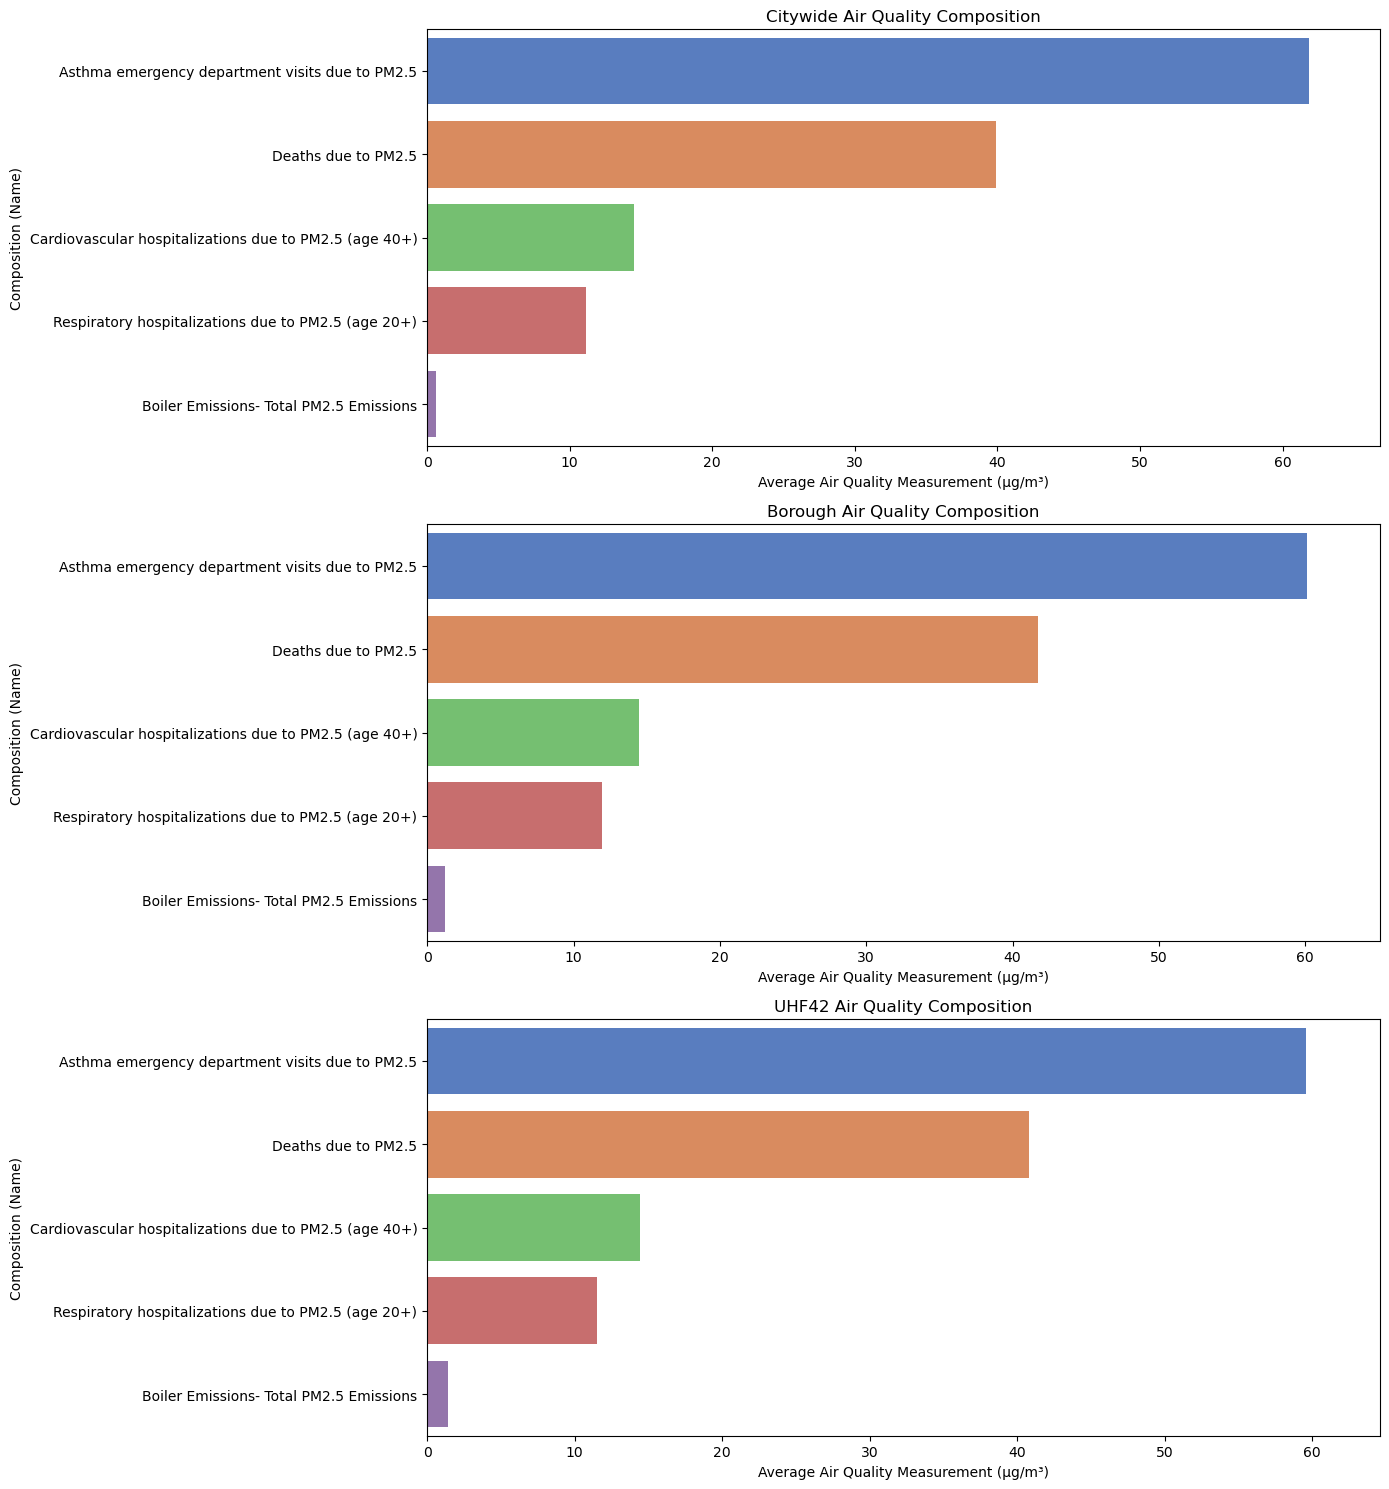

In [79]:
# Filter for 'PM2.5' in the 'Name' column
pm25_data = air_quality_filtered[air_quality_filtered['Name'].str.contains('PM2.5', case=False, na=False)]

# Grouping the filtered data by 'Geo Type Name' and 'Name', calculating the average air quality measurement
composition_analysis = pm25_data.groupby(['Geo Type Name', 'Name'])['Data Value'].mean().reset_index()

# Sorting by average air quality measurement in descending order
composition_analysis.sort_values(by='Data Value', ascending=False, inplace=True)

# Get the unique values of 'Geo Type Name' to create separate plots
geo_types = composition_analysis['Geo Type Name'].unique()

# Set up the matplotlib figure for multiple subplots
fig, axes = plt.subplots(len(geo_types), 1, figsize=(14, 5 * len(geo_types)))

# If there's only one plot, axes is not an array, so we need to handle that case
if len(geo_types) == 1:
    axes = [axes]

# Iterate over each 'Geo Type Name' to create a plot
for i, geo_type in enumerate(geo_types):
    # Filter the data for the current Geo Type Name
    geo_data = composition_analysis[composition_analysis['Geo Type Name'] == geo_type]
    
    # Create a barplot for the current Geo Type Name
    sns.barplot(x='Data Value', y='Name', data=geo_data, ax=axes[i], palette='muted', order=geo_data['Name'].unique())
    
    # Add labels and title
    axes[i].set_xlabel('Average Air Quality Measurement (µg/m³)')
    axes[i].set_ylabel('Composition (Name)')
    axes[i].set_title(f'{geo_type} Air Quality Composition')

    # Set the x-axis limit
    axes[i].set_xlim(0, geo_data['Data Value'].max() + 5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

/tmp/ipykernel_637/232090103.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=worst_air_quality_category, x='Data Value', y='Geo Type Name', palette='viridis')


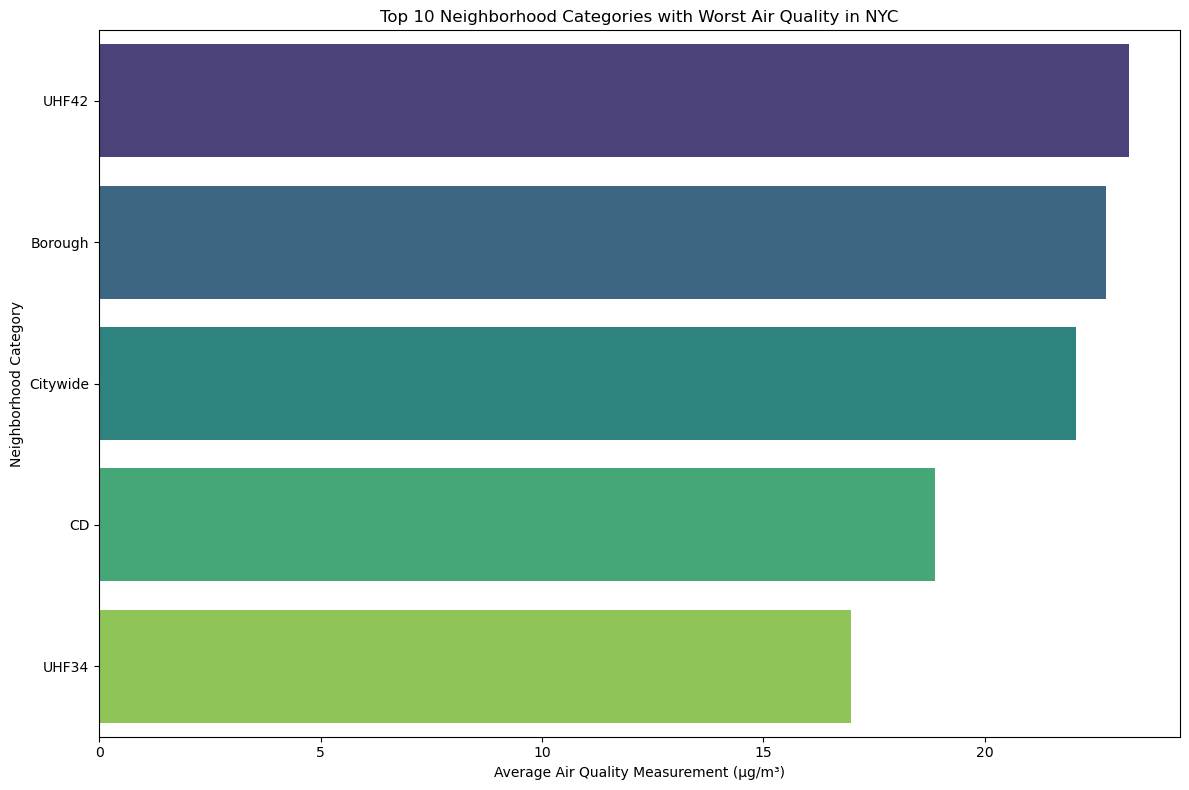

Neighborhood Categories with the Worst Air Quality:
  Geo Type Name  Data Value
4         UHF42   23.248486
0       Borough   22.749536
2      Citywide   22.054305
1            CD   18.880945
3         UHF34   16.982477


In [80]:
# Using groupby to categorize neighborhood category and calculate average air quality
category_air_quality = air_quality_filtered.groupby('Geo Type Name')['Data Value'].mean().reset_index()

# Sorting by air quality measurement in ascending order (worst air quality first)
category_air_quality.sort_values(by='Data Value', ascending=False, inplace=True)
worst_air_quality_category = category_air_quality.head(10)

# Visualization
plt.figure(figsize=(12, 8))
# Plot using 'Geo Type Name' on the y-axis and 'Data Value' on the x-axis
sns.barplot(data=worst_air_quality_category, x='Data Value', y='Geo Type Name', palette='viridis')

plt.title('Top 10 Neighborhood Categories with Worst Air Quality in NYC')
plt.xlabel('Average Air Quality Measurement (µg/m³)')
plt.ylabel('Neighborhood Category')
plt.tight_layout()
plt.show()

# Printing the neighborhood categories with the worst air quality
print("Neighborhood Categories with the Worst Air Quality:")
print(worst_air_quality_category)

#### Using Citywide as a baseline and focusing only on Borough and UHF42

#### merging the pm25_data with borough and uhf42 geojson to make maps

In [81]:
print(uhf42.columns)

Index(['id', 'GEOCODE', 'GEONAME', 'BOROUGH', 'geometry'], dtype='object')


In [82]:
#check unique values in the merge keys
print("Unique Geo Join IDs in pm25_data:")
print(pm25_data['Geo Join ID'].unique())

print("Unique boro_codes in CD:")
print(borough['boro_code'].unique())

Unique Geo Join IDs in pm25_data:
[208. 407. 207. 408. 301. 404. 410. 409. 310.   3. 210. 306. 202. 307.
 308. 107.   2.   1. 302. 402. 305. 403. 203. 105. 303. 103. 201. 501.
 102. 406.   4. 211. 104. 204.   5. 206. 209. 309. 205. 101. 106. 405.
 401. 304. 502. 504. 503.]
Unique boro_codes in CD:
['2' '5' '4' '1' '3']


In [83]:
# Calculate the overall average PM2.5 for each borough across all years
overall_avg = pm25_data.groupby('Geo Place Name')['Data Value'].mean().reset_index()

# Merge the borough data with the PM2.5 average data (overall_avg)
borough_avg_combined = borough.merge(overall_avg, left_on='boro_name', right_on='Geo Place Name', how='left')

# Check the column names to understand the structure
print(borough_avg_combined.columns)

# Select relevant columns and rename for clarity
borough_avg_combined = borough_avg_combined[['boro_name', 'Data Value']]  # Select relevant columns

# Rename the columns for clarity
borough_avg_combined.columns = ['Borough', 'PM2.5_Average']

# Check the result
print(borough_avg_combined.head())

Index(['boro_code', 'boro_name', 'shape_area', 'shape_leng', 'geometry',
       'Geo Place Name', 'Data Value'],
      dtype='object')
         Borough  PM2.5_Average
0          Bronx      52.713636
1  Staten Island      25.090909
2         Queens      23.100000
3      Manhattan      38.154545
4       Brooklyn      32.750000


In [84]:
# Merge the UHF42 data with the PM2.5 average data (overall_avg)
uhf42_avg_combined = uhf42.merge(overall_avg, left_on='GEONAME', right_on='Geo Place Name', how='left')

# Checl the column names to understand the structure
print(uhf42_avg_combined.columns)

# Remove duplicates and aggregate data by region
uhf42_avg_combined_unique = uhf42_avg_combined.groupby('GEONAME').agg({
    'Data Value': 'mean',  
    'geometry': 'first'  
}).reset_index()

# Remane the columns for clarity
uhf42_avg_combined_unique.columns = ['UHF42_Region', 'PM2.5_Average', 'geometry']

# Sort the data by PM2.5_Average in descending order
uhf42_avg_combined_unique = uhf42_avg_combined_unique.sort_values(by='PM2.5_Average', ascending=False)

# Select top 10 UHF42 regions with the highest PM2.5 average
top_10_uhf42 = uhf42_avg_combined_unique.head(10)

# Check the result after selecting top 10
print(top_10_uhf42)

Index(['id', 'GEOCODE', 'GEONAME', 'BOROUGH', 'geometry', 'Geo Place Name',
       'Data Value'],
      dtype='object')
                            UHF42_Region  PM2.5_Average  \
12                           East Harlem      81.304545   
21              Hunts Point - Mott Haven      75.140909   
6   Central Harlem - Morningside Heights      73.990909   
20              High Bridge - Morrisania      72.272727   
2     Bedford Stuyvesant - Crown Heights      54.213636   
41               Williamsburg - Bushwick      52.650000   
13                         East New York      49.650000   
27                  Pelham - Throgs Neck      42.700000   
36        Union Square - Lower East Side      40.972727   
26                       Northeast Bronx      40.468182   

                                             geometry  
12  MULTIPOLYGON (((-73.93673 40.80822, -73.93995 ...  
21  POLYGON ((-73.89216 40.83365, -73.89301 40.835...  
6   POLYGON ((-73.93394 40.80826, -73.9339 40.8186...  
20  PO

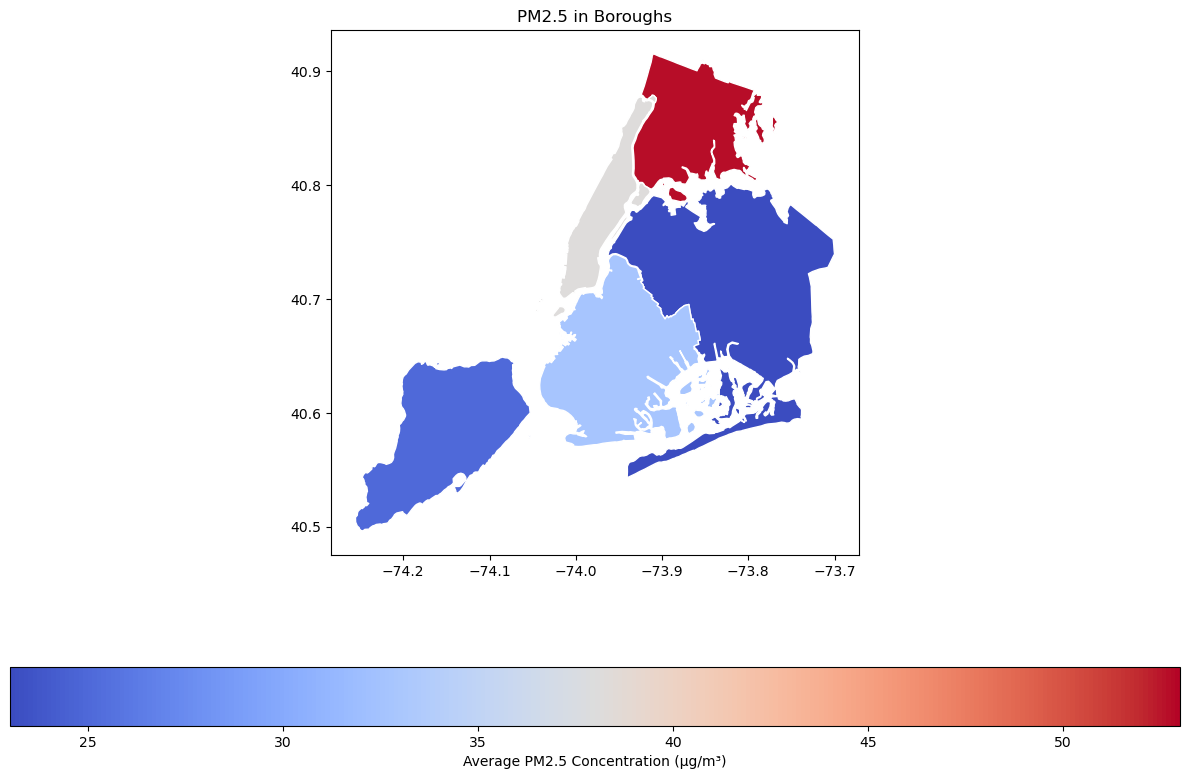

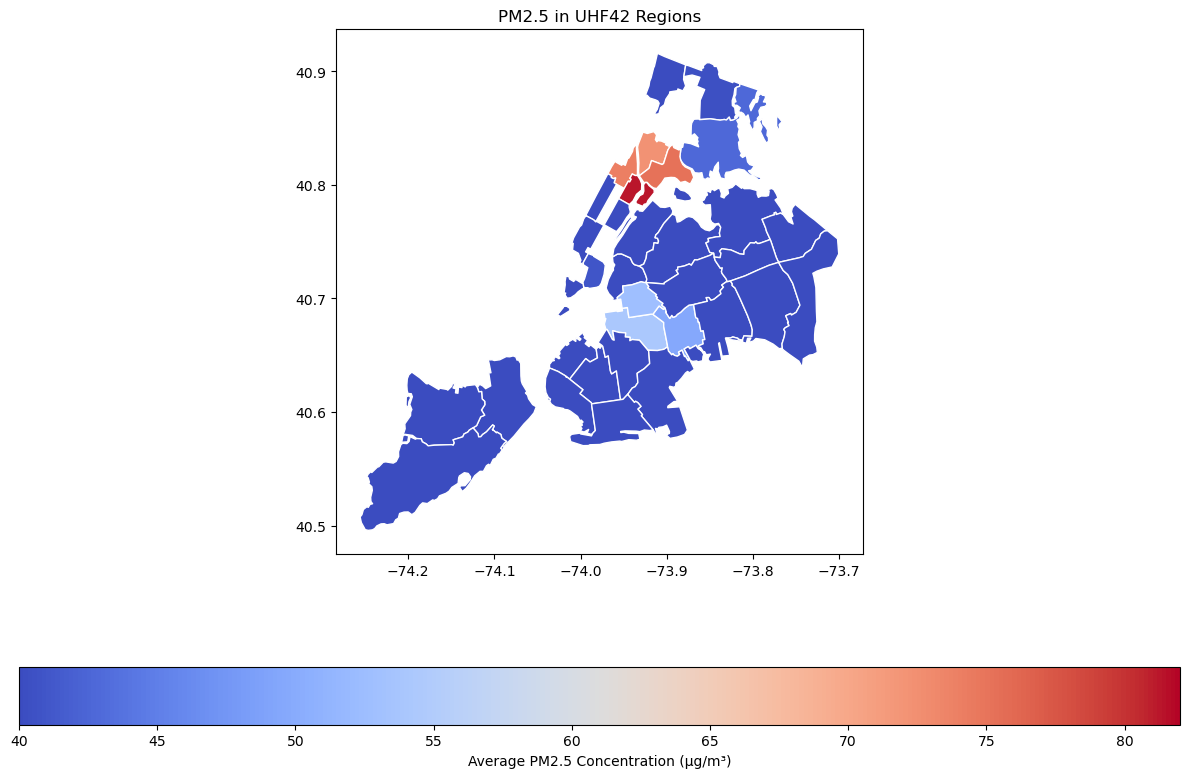

In [85]:
# Plotting the Borough Map using borough_avg_combined
# Ensure borough_avg_combined contains geometry data (GeoDataFrame)
fig, ax = plt.subplots(figsize=(12, 8))  # Create a new figure for the Borough map

# Merge the Borough data with geometry to ensure the map can be plotted correctly
borough_map = borough.merge(borough_avg_combined, left_on='boro_name', right_on='Borough', how='left')

# Plot Borough map with PM2.5 average values
borough_map.plot(column='PM2.5_Average', ax=ax, legend=True,
                 legend_kwds={'label': "Average PM2.5 Concentration (µg/m³)",
                              'orientation': "horizontal"},
                 vmin=23, vmax=53, edgecolor='white', cmap='coolwarm')  # Adjust vmin and vmax based on data
ax.set_title('PM2.5 in Boroughs')

# Save the Borough map to a separate PDF
fig.savefig("borough_map.pdf", format="pdf")

# Finalize layout and display
plt.tight_layout()
plt.show()


# Plotting the UHF42 Map using uhf42_avg_combined_unique
fig, ax = plt.subplots(figsize=(12, 8))  # Create a new figure for the UHF42 map

# Merge the UHF42 data with geometry to ensure the map can be plotted correctly
uhf42_map = uhf42.merge(uhf42_avg_combined_unique, left_on='GEONAME', right_on='UHF42_Region', how='left')

# Check and set the correct geometry column (assumed 'geometry_x' here)
uhf42_map = uhf42_map.set_geometry('geometry_x')  # Adjust if needed based on your GeoDataFrame's structure

# Plot UHF42 map with PM2.5 average values
uhf42_map.plot(column='PM2.5_Average', ax=ax, legend=True,
               legend_kwds={'label': "Average PM2.5 Concentration (µg/m³)",
                            'orientation': "horizontal"},
               vmin=40, vmax=82, edgecolor='white', cmap='coolwarm')  # Adjust vmin and vmax based on data
ax.set_title('PM2.5 in UHF42 Regions')

# Save the UHF42 map to a separate PDF
fig.savefig("uhf42_map.pdf", format="pdf")

# Finalize layout and display
plt.tight_layout()
plt.show()


#### Heatmap for Borough

         Borough  PM2.5_Average
0          Bronx      52.713636
3      Manhattan      38.154545
4       Brooklyn      32.750000
1  Staten Island      25.090909
2         Queens      23.100000


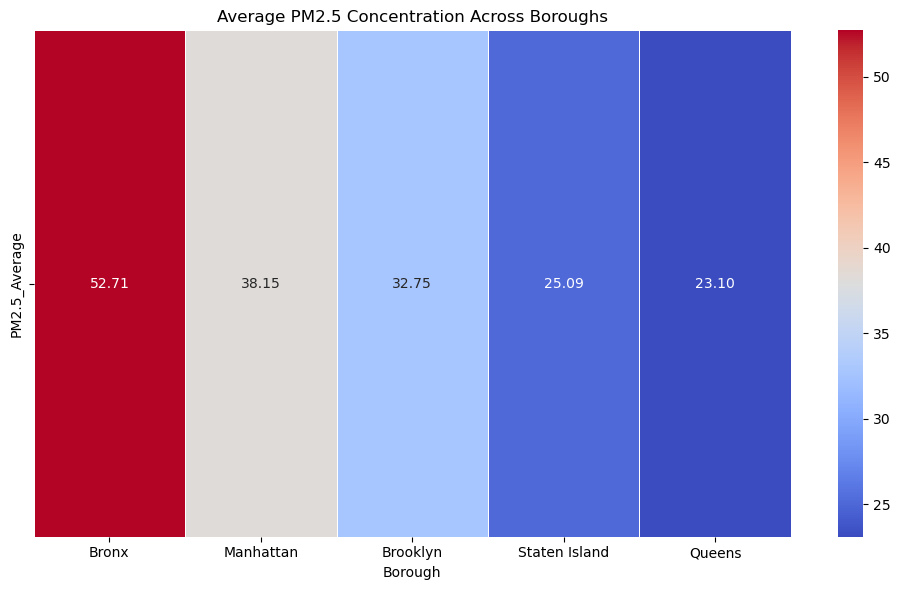

In [86]:
# Sort the data by PM2.5_Average in descending order
borough_avg_combined_unique = borough_avg_combined.sort_values(by='PM2.5_Average', ascending=False)

# Check the result after sorting
print(borough_avg_combined_unique.head())

# Pivot data for heatmap visualization
borough_pivot = borough_avg_combined_unique.set_index('Borough')[['PM2.5_Average']]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(borough_pivot.T, annot=True, cmap='coolwarm', cbar=True, fmt=".2f", linewidths=0.5)
plt.title('Average PM2.5 Concentration Across Boroughs')
plt.tight_layout()
plt.show()

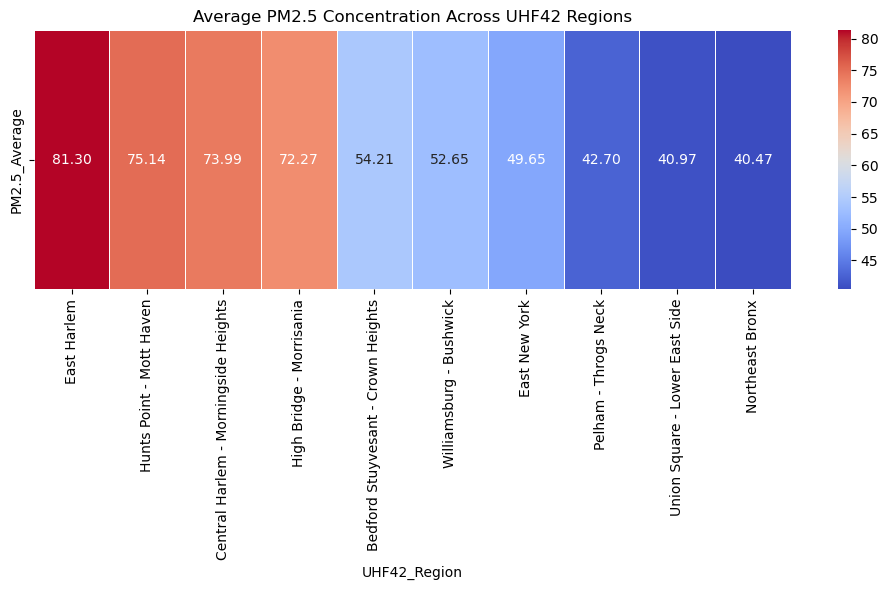

In [87]:
# Pivot data for heatmap visualization
uhf42_pivot = top_10_uhf42.set_index('UHF42_Region')[['PM2.5_Average']]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(uhf42_pivot.T, annot=True, cmap='coolwarm', cbar=True, fmt=".2f", linewidths=0.5)
plt.title('Average PM2.5 Concentration Across UHF42 Regions')
plt.tight_layout()
plt.show()

### Objective - Comparative time-series analysis to identify the pattern of air quality from 2009 to 2022
### Hypothesis (H2): PM2.5 levels in New York City have shown a decreasing trend from 2009 to 2022, indicating an improvement in air quality.

/tmp/ipykernel_637/2287160137.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm25_data_filtered['Start_Date'] = pd.to_datetime(pm25_data_filtered['Start_Date'], errors='coerce')


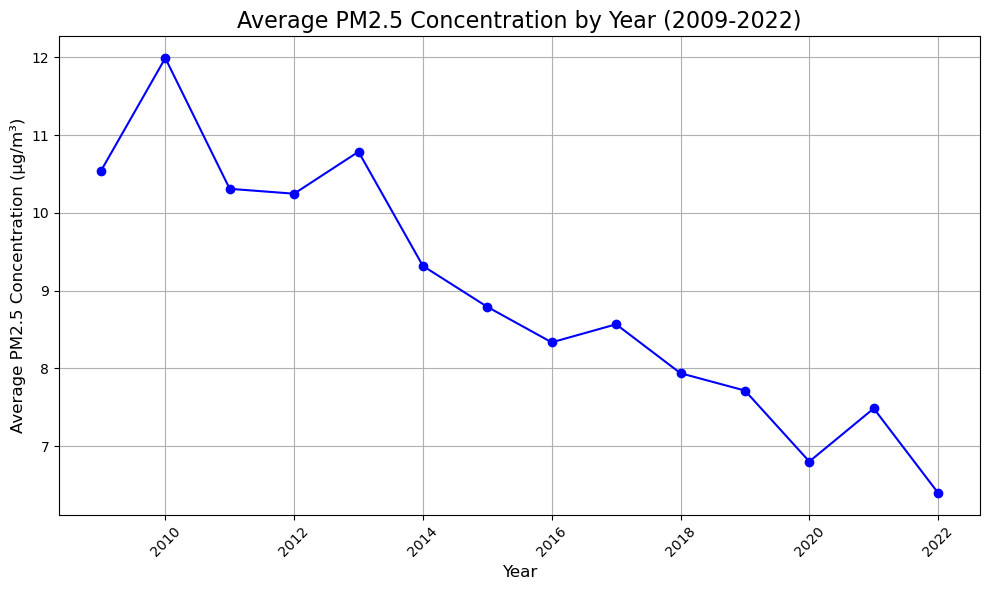

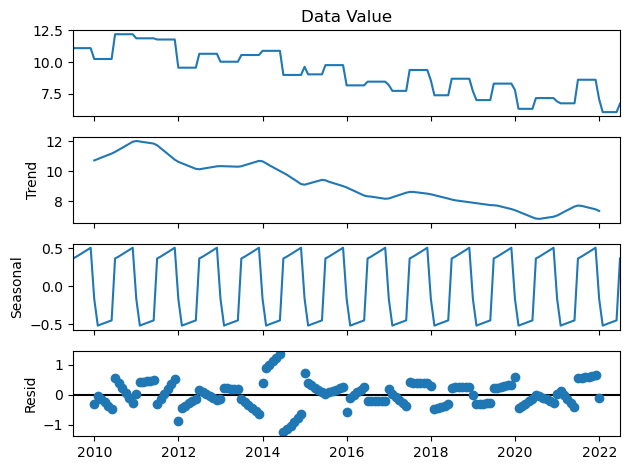

In [88]:
# Filter and data for "Fine particles (PM 2.5)" in 'Name' column
pm25_data_filtered = air_quality_filtered[air_quality_filtered['Name'] == 'Fine particles (PM 2.5)']

# Convert 'Start_Date' to datetime 
pm25_data_filtered['Start_Date'] = pd.to_datetime(pm25_data_filtered['Start_Date'], errors='coerce')

# Filter data for the period 2009-2022
pm25_data_filtered = pm25_data_filtered[(pm25_data_filtered['Start_Date'].dt.year >= 2009) &
                                         (pm25_data_filtered['Start_Date'].dt.year <= 2022)]

# Group by year and calculate the average PM2.5 concentration
pm25_data_filtered['Year'] = pm25_data_filtered['Start_Date'].dt.year
pm25_data_filtered['Month'] = pm25_data_filtered['Start_Date'].dt.month

# Group by Year and calculate the average PM2.5 concentration per year
pm25_yearly = pm25_data_filtered.groupby('Year')['Data Value'].mean().reset_index()

# Plot the Time Series for PM2.5
plt.figure(figsize=(10, 6))
plt.plot(pm25_yearly['Year'], pm25_yearly['Data Value'], marker='o', linestyle='-', color='b')
plt.title('Average PM2.5 Concentration by Year (2009-2022)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average PM2.5 Concentration (µg/m³)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time Series Decomposition
pm25_data_filtered.set_index('Start_Date', inplace=True)

# Resample the data to monthly frequency and calculate the mean PM2.5 value per month
pm25_monthly = pm25_data_filtered['Data Value'].resample('M').mean()

# Fill missing values using forward fill
pm25_monthly_filled = pm25_monthly.ffill()  

# Check if we have enough data points (at least 24)
if len(pm25_monthly_filled) >= 24:
    decomposition = sm.tsa.seasonal_decompose(pm25_monthly_filled, model='additive', period=12)
    decomposition.plot()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data points for seasonal decomposition.")

In [89]:
# Check if the data is skewed, before performing the analysis
skewness = pm25_monthly_filled.skew()
print(f"Skewness of PM2.5 data: {skewness}")

Skewness of PM2.5 data: 0.05312041061060736


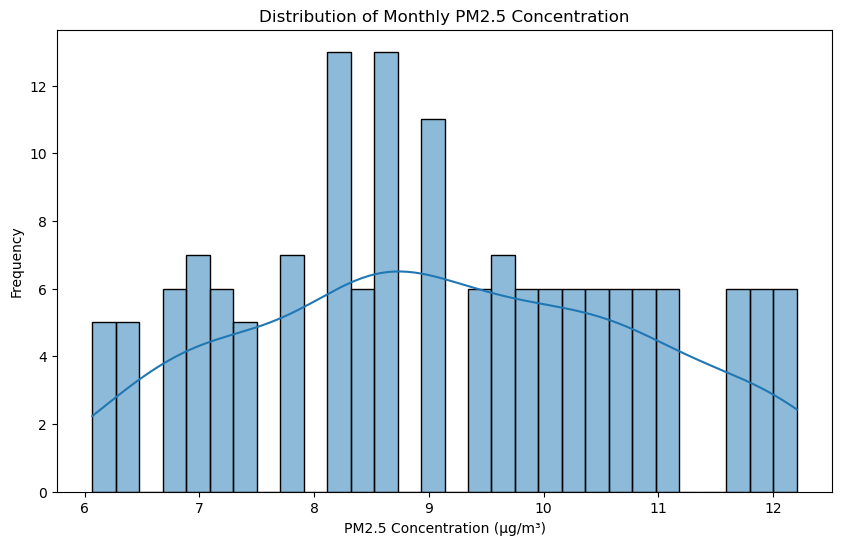

In [90]:
# Plot histogram for the distribution of PM2.5 (monthly filled data)
plt.figure(figsize=(10, 6))
sns.histplot(pm25_monthly_filled, bins=30, kde=True)
plt.title('Distribution of Monthly PM2.5 Concentration')
plt.xlabel('PM2.5 Concentration (µg/m³)')
plt.ylabel('Frequency')
plt.show()

#### Augmented Dickey-Fuller Test

In [91]:
# Perform ADF test on the PM2.5 data
result = adfuller(pm25_monthly_filled.dropna())  #Dropping NaN
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpretation of p-value
if result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

ADF Statistic: -0.614285084118284
p-value: 0.8677214026498994
The time series is non-stationary.


#### Differencing the timeseries data - to make it stationary

In [92]:
# First-order differencing
pm25_diff = pm25_monthly_filled.diff().dropna()

# Perform the ADF test again to check if the differenced series is stationary
result = adfuller(pm25_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("The differenced time series is stationary.")
else:
    print("The differenced time series is still non-stationary.")

ADF Statistic: -8.593892429770564
p-value: 7.163528322744075e-14
The differenced time series is stationary.


####  ACF and PACF to understand the structure of time series

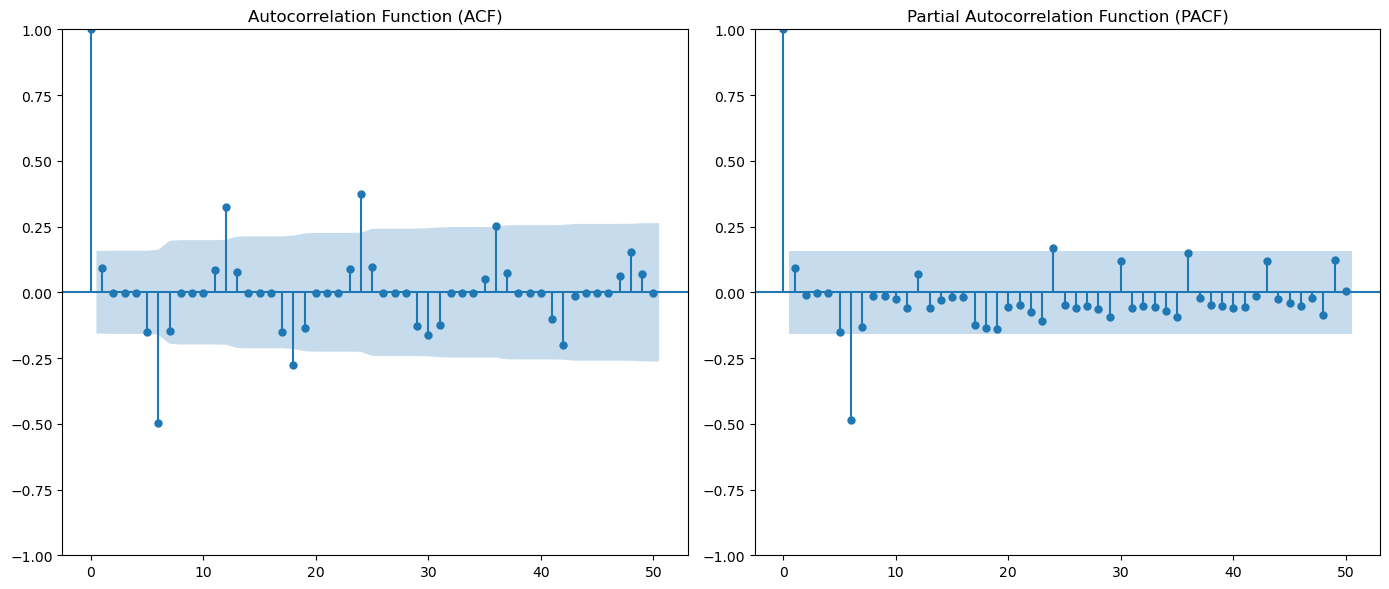

In [93]:
# Plot ACF and PACF for the differenced data
plt.figure(figsize=(14, 6))

# ACF plot
plt.subplot(121)
plot_acf(pm25_diff, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# PACF plot
plt.subplot(122)
plot_pacf(pm25_diff, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

#### ARIMA

In [94]:
# Fitting an ARIMA model with the parameters (p=6, d=1, q=4)
model = ARIMA(pm25_diff, order=(6, 1, 4))  # Adjust p and q based on ACF/PACF results
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Data Value   No. Observations:                  156
Model:                 ARIMA(6, 1, 4)   Log Likelihood                 -93.499
Date:                Sun, 08 Dec 2024   AIC                            208.998
Time:                        14:42:43   BIC                            242.476
Sample:                    07-31-2009   HQIC                           222.596
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6986      0.250      2.800      0.005       0.210       1.188
ar.L2         -0.7447      0.291     -2.560      0.010      -1.315      -0.174
ar.L3          0.5365      0.323      1.662      0.0

/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Forecasting

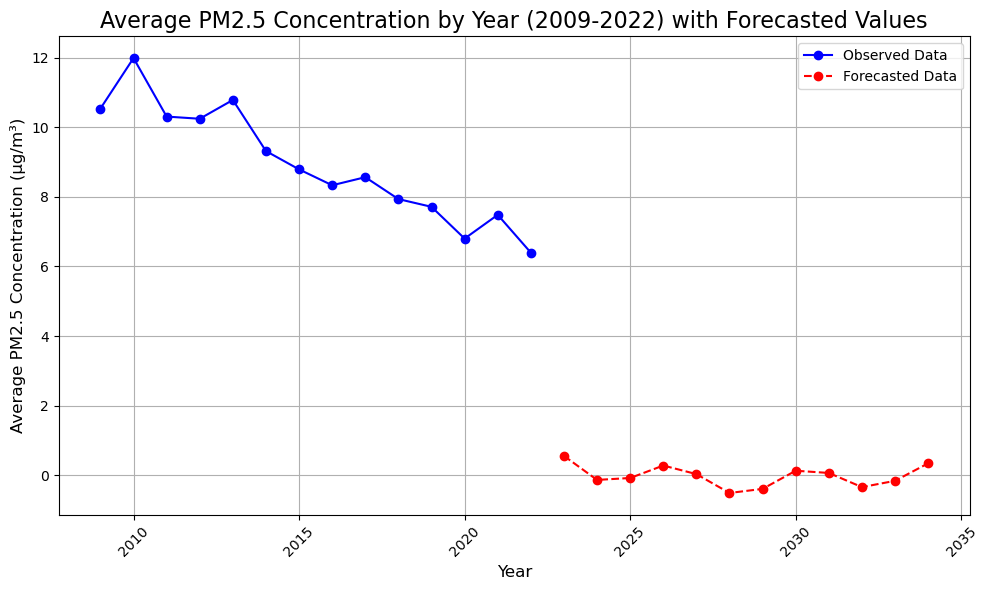

In [95]:
# Forecast the next few years
forecast_steps = 12  
forecast = model_fit.forecast(steps=forecast_steps)

# Create a date range for the forecast period
forecast_years = range(pm25_yearly['Year'].iloc[-1] + 1, pm25_yearly['Year'].iloc[-1] + 1 + forecast_steps)

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame({
    'Year': forecast_years,
    'Data Value': forecast
})

# Plot the Time Series for PM2.5 (Observed data)
plt.figure(figsize=(10, 6))

# Plot the observed data (Yearly)
plt.plot(pm25_yearly['Year'], pm25_yearly['Data Value'], marker='o', linestyle='-', color='b', label='Observed Data')

# Plot the forecasted data (Next 12 months)
plt.plot(forecast_df['Year'], forecast_df['Data Value'], marker='o', linestyle='--', color='r', label='Forecasted Data')

# Adding titles and labels
plt.title('Average PM2.5 Concentration by Year (2009-2022) with Forecasted Values', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average PM2.5 Concentration (µg/m³)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

#### Objective - Understanding the number of asthma, and respiratory and cardiovascular hospitalization due to PM2.5 in the age group of 20+ and 40+, respectively
#### Hypothesis 3 (H3): PM2.5 exposure has contributed to an increase in asthma, and other respiratory and cardiovascular hospitalizations, particularly in the age groups 20+ and 40+ over the past decade.

In [96]:
# Prepare to merge the three datasets asthna, resp_hospitalizations and cv_hospitalizations
print(cv_hospitalizations.head())
print(cv_hospitalizations.info())

  TimePeriod GeoTypeDesc  GeoID  GeoRank      Geography  \
0  2017-2019    Citywide      1        0  New York City   
1  2017-2019     Borough      1        1          Bronx   
2  2017-2019     Borough      2        1       Brooklyn   
3  2017-2019     Borough      3        1      Manhattan   
4  2017-2019     Borough      4        1         Queens   

   Estimated annual number Estimated annual rate per 100,000 adults  
0                    387.0                                     10.0  
1                     75.0                                     12.0  
2                    126.0                                     11.0  
3                     70.0                                      9.0  
4                     89.0                                      8.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    ---

In [97]:
print(resp_hospitalizations.head())
print(resp_hospitalizations.info())

  TimePeriod GeoType  GeoID  GeoRank                Geography  \
0  2017-2019   UHF42    101        4  Kingsbridge - Riverdale   
1  2017-2019   UHF42    102        4          Northeast Bronx   
2  2017-2019   UHF42    103        4       Fordham - Bronx Pk   
3  2017-2019   UHF42    104        4     Pelham - Throgs Neck   
4  2017-2019   UHF42    105        4         Crotona -Tremont   

  Estimated annual number  Estimated annual rate per 100,000 adults  
0                     7.0                                       9.0  
1                    16.0                                      10.0  
2                    23.0                                      11.0  
3                    24.0                                      10.0  
4                    20.0                                      13.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------   

In [98]:
print(air_quality_filtered.head())
print(air_quality_filtered.info())

   Unique ID  Indicator ID                                   Name  \
0     179772           640  Boiler Emissions- Total SO2 Emissions   
1     179785           640  Boiler Emissions- Total SO2 Emissions   
2     178540           365                Fine particles (PM 2.5)   
3     178561           365                Fine particles (PM 2.5)   
4     823217           365                Fine particles (PM 2.5)   

          Measure Measure Info Geo Type Name  Geo Join ID  \
0  Number per km2       number         UHF42        409.0   
1  Number per km2       number         UHF42        209.0   
2            Mean       mcg/m3         UHF42        209.0   
3            Mean       mcg/m3         UHF42        409.0   
4            Mean       mcg/m3         UHF42        409.0   

            Geo Place Name          Time Period Start_Date  Data Value  
0         Southeast Queens                 2015 2015-01-01         0.3  
1  Bensonhurst - Bay Ridge                 2015 2015-01-01         1.2  

In [99]:
print(asthma.head())
print(asthma.info())

  TimePeriod GeoType  GeoID  GeoRank                Geography  \
0  2017-2019   UHF42    101        4  Kingsbridge - Riverdale   
1  2017-2019   UHF42    102        4          Northeast Bronx   
2  2017-2019   UHF42    103        4       Fordham - Bronx Pk   
3  2017-2019   UHF42    104        4     Pelham - Throgs Neck   
4  2017-2019   UHF42    105        4         Crotona -Tremont   

  Estimated annual number (age 18+) Estimated annual number (under age 18)  \
0                              13.0                                    9.0   
1                              61.0                                   37.0   
2                             101.0                                   79.0   
3                              83.0                                   58.0   
4                             110.0                                   74.0   

   Estimated annual rate (age 18+) per 100,000 adults  \
0                                               16.0    
1                         

In [100]:
# For cv_hospitalizations: Normalizing the 'TimePeriod' column to extract the starting year
cv_hospitalizations['Start_Year'] = cv_hospitalizations['TimePeriod'].str.split('-').str[0].astype(int)

# Check the changes for cv_hospitalizations
print("cv_hospitalizations - Start Year Extraction:")
print(cv_hospitalizations[['TimePeriod', 'Start_Year']].head())

# For resp_hospitalizations: Extracting start year from 'TimePeriod'
resp_hospitalizations['Start_Year'] = resp_hospitalizations['TimePeriod'].str.split('-').str[0].astype(int)

# Check the changes for resp_hospitalizations
print("resp_hospitalizations - Start Year Extraction:")
print(resp_hospitalizations[['TimePeriod', 'Start_Year']].head())

# For asthma: Extracting start year from 'TimePeriod'
asthma['Start_Year'] = asthma['TimePeriod'].str.split('-').str[0].astype(int)

# Check the changes for asthma
print("asthma - Start Year Extraction:")
print(asthma[['TimePeriod', 'Start_Year']].head())

# Additional check: Rows with missing Start_Year
missing_start_year_cv = cv_hospitalizations[cv_hospitalizations['Start_Year'].isnull()]
missing_start_year_resp = resp_hospitalizations[resp_hospitalizations['Start_Year'].isnull()]
missing_start_year_asthma = asthma[asthma['Start_Year'].isnull()]

print(f"Rows with missing Start_Year in cv_hospitalizations: {missing_start_year_cv.shape[0]}")
print(f"Rows with missing Start_Year in resp_hospitalizations: {missing_start_year_resp.shape[0]}")
print(f"Rows with missing Start_Year in asthma: {missing_start_year_asthma.shape[0]}")

# Fill missing Start_Year in both datasets
cv_hospitalizations['Start_Year'].fillna(0, inplace=True)  # Filling with 0
resp_hospitalizations['Start_Year'].fillna(0, inplace=True)  # Same for resp_hospitalizations
asthma['Start_Year'].fillna(0, inplace=True)  # Same for asthma

# Recheck after filling missing values
print("After filling missing Start_Year:")
print(cv_hospitalizations[['TimePeriod', 'Start_Year']].head())
print(resp_hospitalizations[['TimePeriod', 'Start_Year']].head())
print(asthma[['TimePeriod', 'Start_Year']].head())

cv_hospitalizations - Start Year Extraction:
  TimePeriod  Start_Year
0  2017-2019        2017
1  2017-2019        2017
2  2017-2019        2017
3  2017-2019        2017
4  2017-2019        2017
resp_hospitalizations - Start Year Extraction:
  TimePeriod  Start_Year
0  2017-2019        2017
1  2017-2019        2017
2  2017-2019        2017
3  2017-2019        2017
4  2017-2019        2017
asthma - Start Year Extraction:
  TimePeriod  Start_Year
0  2017-2019        2017
1  2017-2019        2017
2  2017-2019        2017
3  2017-2019        2017
4  2017-2019        2017
Rows with missing Start_Year in cv_hospitalizations: 0
Rows with missing Start_Year in resp_hospitalizations: 0
Rows with missing Start_Year in asthma: 0
After filling missing Start_Year:
  TimePeriod  Start_Year
0  2017-2019        2017
1  2017-2019        2017
2  2017-2019        2017
3  2017-2019        2017
4  2017-2019        2017
  TimePeriod  Start_Year
0  2017-2019        2017
1  2017-2019        2017
2  2017-2019 

In [101]:
#Checl unique geography values for both datasets
print(cv_hospitalizations['Geography'].unique())
print(resp_hospitalizations['Geography'].unique())
print(asthma['Geography'].unique())
print(air_quality_filtered['Geo Place Name'].unique())  

['New York City' 'Bronx' 'Brooklyn' 'Manhattan' 'Queens' 'Staten Island'
 'Kingsbridge - Riverdale' 'Northeast Bronx' 'Fordham - Bronx Pk'
 'Pelham - Throgs Neck' 'Crotona -Tremont' 'High Bridge - Morrisania'
 'Hunts Point - Mott Haven' 'Greenpoint' 'Downtown - Heights - Slope'
 'Bedford Stuyvesant - Crown Heights' 'East New York' 'Sunset Park'
 'Borough Park' 'East Flatbush - Flatbush' 'Canarsie - Flatlands'
 'Bensonhurst - Bay Ridge' 'Coney Island - Sheepshead Bay'
 'Williamsburg - Bushwick' 'Washington Heights'
 'Central Harlem - Morningside Heights' 'East Harlem' 'Upper West Side'
 'Upper East Side' 'Chelsea - Clinton' 'Gramercy Park - Murray Hill'
 'Greenwich Village - SoHo' 'Union Square - Lower East Side'
 'Lower Manhattan' 'Long Island City - Astoria' 'West Queens'
 'Flushing - Clearview' 'Bayside - Little Neck' 'Ridgewood - Forest Hills'
 'Fresh Meadows' 'Southwest Queens' 'Jamaica' 'Southeast Queens'
 'Rockaways' 'Port Richmond' 'Stapleton - St. George' 'Willowbrook'
 'South 

In [102]:
# Check the data types of the columns
print(cv_hospitalizations['Start_Year'].dtype)
print(resp_hospitalizations['Start_Year'].dtype)
print(asthma['Start_Year'].dtype)
print(air_quality_filtered['Start_Date'].dtype)

int64
int64
int64
datetime64[ns]


In [103]:
# Print column names of air_quality to see if 'Start_Year' exists
print(air_quality_filtered.columns)

Index(['Unique ID', 'Indicator ID', 'Name', 'Measure', 'Measure Info',
       'Geo Type Name', 'Geo Join ID', 'Geo Place Name', 'Time Period',
       'Start_Date', 'Data Value'],
      dtype='object')


In [104]:
# Extract the year from 'Start_Date'
air_quality_filtered['Start_Year'] = air_quality_filtered['Start_Date'].dt.year.astype(int)

# Check the conversion
print("air_quality - Start Year Conversion:")
print(air_quality_filtered[['Geo Place Name', 'Start_Year', 'Data Value']].head())

# Confirm the data type change
print("Data type of 'Start_Year' in air_quality:", air_quality_filtered['Start_Year'].dtype)

air_quality - Start Year Conversion:
            Geo Place Name  Start_Year  Data Value
0         Southeast Queens        2015         0.3
1  Bensonhurst - Bay Ridge        2015         1.2
2  Bensonhurst - Bay Ridge        2011         8.6
3         Southeast Queens        2011         8.0
4         Southeast Queens        2022         6.1
Data type of 'Start_Year' in air_quality: int64


/tmp/ipykernel_637/2330814497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_quality_filtered['Start_Year'] = air_quality_filtered['Start_Date'].dt.year.astype(int)


In [105]:
# Ensure 'Start_Year' in both datasets is an object type (string) to match the format in air_quality
cv_hospitalizations['Start_Year'] = cv_hospitalizations['Start_Year'].astype(int)
resp_hospitalizations['Start_Year'] = resp_hospitalizations['Start_Year'].astype(int)
asthma['Start_Year'] = asthma['Start_Year'].astype(int)

# Clean the 'GeoPlaceName' columns for cv_hospitalizations, resp_hospitalizations and asthma 
cv_hospitalizations['Geography'] = cv_hospitalizations['Geography'].str.strip().str.lower()
resp_hospitalizations['Geography'] = resp_hospitalizations['Geography'].str.strip().str.lower()
asthma['Geography'] = asthma['Geography'].str.strip().str.lower()

# Clean the 'Geo Place Name' column in air_quality
air_quality_filtered['Geo Place Name'] = air_quality_filtered['Geo Place Name'].str.strip().str.lower()

/tmp/ipykernel_637/275883514.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_quality_filtered['Geo Place Name'] = air_quality_filtered['Geo Place Name'].str.strip().str.lower()


In [106]:
# Check the columns in cv_hospitalizations to confirm if 'Start_Year' exists
print("cv_hospitalizations columns:", cv_hospitalizations.columns)

# Check the columns in resp_hospitalizations to confirm if 'Start_Year' exists
print("resp_hospitalizations columns:", resp_hospitalizations.columns)

# Check the columns in asthma to confirm if 'Start_Year' exists
print("asthma columns:", asthma.columns)

# Check if 'Start_Year' exists in both datasets before converting to int
if 'Start_Year' in cv_hospitalizations.columns:
    cv_hospitalizations['Start_Year'] = cv_hospitalizations['Start_Year'].astype(int)
else:
    print("Start_Year column not found in cv_hospitalizations")

if 'Start_Year' in resp_hospitalizations.columns:
    resp_hospitalizations['Start_Year'] = resp_hospitalizations['Start_Year'].astype(int)
else:
    print("Start_Year column not found in resp_hospitalizations")

if 'Start_Year' in asthma.columns:
    asthma['Start_Year'] = asthma['Start_Year'].astype(int)
else:
    print("Start_Year column not found in asthma")

cv_hospitalizations columns: Index(['TimePeriod', 'GeoTypeDesc', 'GeoID', 'GeoRank', 'Geography',
       'Estimated annual number', 'Estimated annual rate per 100,000 adults',
       'Start_Year'],
      dtype='object')
resp_hospitalizations columns: Index(['TimePeriod', 'GeoType', 'GeoID', 'GeoRank', 'Geography',
       'Estimated annual number', 'Estimated annual rate per 100,000 adults',
       'Start_Year'],
      dtype='object')
asthma columns: Index(['TimePeriod', 'GeoType', 'GeoID', 'GeoRank', 'Geography',
       'Estimated annual number (age 18+)',
       'Estimated annual number (under age 18)',
       'Estimated annual rate (age 18+) per 100,000 adults',
       'Estimated annual rate (under age 18) per 100,000 children',
       'Start_Year'],
      dtype='object')


In [107]:
# Drop the specified columns from the asthma dataset as they are not required in merging
asthma_cleaned = asthma.drop(columns=['Estimated annual number (age 18+)', 'Estimated annual number (under age 18)'])

# Check the result to confirm columns have been dropped
print(asthma_cleaned.head())

  TimePeriod GeoType  GeoID  GeoRank                Geography  \
0  2017-2019   UHF42    101        4  kingsbridge - riverdale   
1  2017-2019   UHF42    102        4          northeast bronx   
2  2017-2019   UHF42    103        4       fordham - bronx pk   
3  2017-2019   UHF42    104        4     pelham - throgs neck   
4  2017-2019   UHF42    105        4         crotona -tremont   

   Estimated annual rate (age 18+) per 100,000 adults  \
0                                               16.0    
1                                               36.0    
2                                               49.0    
3                                               34.0    
4                                               67.0    

   Estimated annual rate (under age 18) per 100,000 children  Start_Year  
0                                               48.0                2017  
1                                               81.0                2017  
2                                        

In [108]:
# Check for matching rows in the asthma dataset for each of the conditions
asthma_condition_1 = asthma[(asthma['Estimated annual rate (under age 18) per 100,000 children'].notnull())]
asthma_condition_2 = asthma[(asthma['Estimated annual rate (age 18+) per 100,000 adults'].notnull())]


# Output how many rows match each condition
print(f"Matching rows for under 18 per 100,000 children: {asthma_condition_1.shape[0]}")
print(f"Matching rows for age 18+ per 100,000 adults: {asthma_condition_2.shape[0]}")

Matching rows for under 18 per 100,000 children: 156
Matching rows for age 18+ per 100,000 adults: 156


In [109]:
# Merge for 'Measure' = 'Estimated annual rate (under age 18)' and 'Measure Info' = 'per 100,000 children'
asthma_merged_1 = pd.merge(
    air_quality_filtered[(air_quality_filtered['Measure'] == 'Estimated annual rate (under age 18)') & 
                (air_quality_filtered['Measure Info'] == 'per 100,000 children')],
    asthma[['Start_Year', 'Geography', 'Estimated annual rate (under age 18) per 100,000 children']],
    left_on=['Start_Year', 'Geo Place Name'],
    right_on=['Start_Year', 'Geography'],
    how='left'
)

# Merge for 'Measure' = 'Estimated annual rate (age 18+)' and 'Measure Info' = 'per 100,000 adults'
asthma_merged_2 = pd.merge(
    air_quality_filtered[(air_quality_filtered['Measure'] == 'Estimated annual rate (age 18+)') & 
                (air_quality_filtered['Measure Info'] == 'per 100,000 adults')],
    asthma[['Start_Year', 'Geography', 'Estimated annual rate (age 18+) per 100,000 adults']],
    left_on=['Start_Year', 'Geo Place Name'],
    right_on=['Start_Year', 'Geography'],
    how='left'
)

# Concatenate the tables
final_merged_asthma = pd.concat([asthma_merged_1, asthma_merged_2])

# Check
print(final_merged_asthma)

     Unique ID  Indicator ID                                             Name  \
0       131425           648  Asthma emergency department visits due to PM2.5   
1       131445           648  Asthma emergency department visits due to PM2.5   
2       131424           648  Asthma emergency department visits due to PM2.5   
3       628472           648  Asthma emergency department visits due to PM2.5   
4       628471           648  Asthma emergency department visits due to PM2.5   
..         ...           ...                                              ...   
571     628525           657  Asthma emergency department visits due to PM2.5   
572     518966           657  Asthma emergency department visits due to PM2.5   
573     151588           661             Asthma hospitalizations due to Ozone   
574     827392           657  Asthma emergency department visits due to PM2.5   
575     628519           657  Asthma emergency department visits due to PM2.5   

                           

In [110]:
# Change the asthma column names
final_merged_asthma.rename(columns={'Estimated annual rate (under age 18) per 100,000 children': 'Asthma_under18'}, inplace=True)
final_merged_asthma.rename(columns={'Estimated annual rate (age 18+) per 100,000 adults': 'Asthma_18+'}, inplace=True)
print(final_merged_asthma.head())

   Unique ID  Indicator ID                                             Name  \
0     131425           648  Asthma emergency department visits due to PM2.5   
1     131445           648  Asthma emergency department visits due to PM2.5   
2     131424           648  Asthma emergency department visits due to PM2.5   
3     628472           648  Asthma emergency department visits due to PM2.5   
4     628471           648  Asthma emergency department visits due to PM2.5   

                                Measure          Measure Info Geo Type Name  \
0  Estimated annual rate (under age 18)  per 100,000 children         UHF42   
1  Estimated annual rate (under age 18)  per 100,000 children         UHF42   
2  Estimated annual rate (under age 18)  per 100,000 children         UHF42   
3  Estimated annual rate (under age 18)  per 100,000 children         UHF42   
4  Estimated annual rate (under age 18)  per 100,000 children         UHF42   

   Geo Join ID            Geo Place Name Time Peri

In [111]:
# For cv_hospitalizations
cv_condition_1 = cv_hospitalizations[
    (cv_hospitalizations['GeoTypeDesc'].isin(air_quality_filtered['Geo Type Name'].unique())) &
    (cv_hospitalizations['Start_Year'].isin(air_quality_filtered['Start_Year'].unique())) &
    (cv_hospitalizations['Geography'].isin(air_quality_filtered['Geo Place Name'].unique())) &
    (cv_hospitalizations['Estimated annual rate per 100,000 adults'].notnull())  
]

print(f"Matching rows for cv_hospitalizations: {cv_condition_1.shape[0]}")

# For resp_hospitalizations
resp_condition_1 = resp_hospitalizations[
    (resp_hospitalizations['GeoType'].isin(air_quality_filtered['Geo Type Name'].unique())) &
    (resp_hospitalizations['Start_Year'].isin(air_quality_filtered['Start_Year'].unique())) &
    (resp_hospitalizations['Geography'].isin(air_quality_filtered['Geo Place Name'].unique())) &
    (resp_hospitalizations['Estimated annual rate per 100,000 adults'].notnull()) 
]

print(f"Matching rows for resp_hospitalizations: {resp_condition_1.shape[0]}")


Matching rows for cv_hospitalizations: 24
Matching rows for resp_hospitalizations: 150


In [112]:
# Merge cv_hospitalizations with air_quality based on the specified logic
cv_hospitalization_merged = pd.merge(
    air_quality_filtered[air_quality_filtered['Name'] == 'Cardiovascular hospitalizations due to PM2.5 (age 40+)'],  # Filter for matching 'Name'
    cv_hospitalizations[['Start_Year', 'Geography', 'Estimated annual rate per 100,000 adults']],  # Columns to merge
    left_on=['Start_Year', 'Geo Place Name'],  # Matching columns in air_quality (removed Geo Type Name from merge criteria)
    right_on=['Start_Year', 'Geography'],  # Matching columns in cv_hospitalizations
    how='left'  # Keep all air_quality data
)

cv_hospitalization_merged.rename(columns={'Estimated annual rate per 100,000 adults': 'cv_adults'}, inplace=True)

# Merge resp_hospitalizations with air_quality based on the specified logic
resp_hospitalization_merged = pd.merge(
    air_quality_filtered[air_quality_filtered['Name'] == 'Respiratory hospitalizations due to PM2.5 (age 20+)'],  
    resp_hospitalizations[['Start_Year', 'Geography', 'Estimated annual rate per 100,000 adults']],  
    left_on=['Start_Year', 'Geo Place Name'],  
    right_on=['Start_Year', 'Geography'],  
    how='left'  
)

resp_hospitalization_merged.rename(columns={'Estimated annual rate per 100,000 adults': 'resp_adults'}, inplace=True)

# Check the merged datasets
print(cv_hospitalization_merged.head())
print(resp_hospitalization_merged.head())

   Unique ID  Indicator ID                                               Name  \
0     628611           651  Cardiovascular hospitalizations due to PM2.5 (...   
1     518862           651  Cardiovascular hospitalizations due to PM2.5 (...   
2     518837           651  Cardiovascular hospitalizations due to PM2.5 (...   
3     518866           651  Cardiovascular hospitalizations due to PM2.5 (...   
4     628586           651  Cardiovascular hospitalizations due to PM2.5 (...   

                 Measure        Measure Info Geo Type Name  Geo Join ID  \
0  Estimated annual rate  per 100,000 adults         UHF42        403.0   
1  Estimated annual rate  per 100,000 adults         UHF42        305.0   
2  Estimated annual rate  per 100,000 adults       Borough          3.0   
3  Estimated annual rate  per 100,000 adults         UHF42        309.0   
4  Estimated annual rate  per 100,000 adults         UHF42        106.0   

                   Geo Place Name Time Period Start_Date  Data

#### Final merging of datasets

In [113]:
# Merge the final_merged_asthma, cv_hospitalization_merged, and resp_hospitalization_merged datasets
final_merged = pd.merge(
    final_merged_asthma,
    cv_hospitalization_merged[['Start_Year', 'Geo Place Name', 'cv_adults']], 
    on=['Start_Year', 'Geo Place Name'],
    how='left'
)

final_merged = pd.merge(
    final_merged,
    resp_hospitalization_merged[['Start_Year', 'Geo Place Name', 'resp_adults']],
    on=['Start_Year', 'Geo Place Name'],
    how='left'
)

# Check the merged dataset
print(final_merged.head())

   Unique ID  Indicator ID                                             Name  \
0     131425           648  Asthma emergency department visits due to PM2.5   
1     131445           648  Asthma emergency department visits due to PM2.5   
2     131424           648  Asthma emergency department visits due to PM2.5   
3     628472           648  Asthma emergency department visits due to PM2.5   
4     628471           648  Asthma emergency department visits due to PM2.5   

                                Measure          Measure Info Geo Type Name  \
0  Estimated annual rate (under age 18)  per 100,000 children         UHF42   
1  Estimated annual rate (under age 18)  per 100,000 children         UHF42   
2  Estimated annual rate (under age 18)  per 100,000 children         UHF42   
3  Estimated annual rate (under age 18)  per 100,000 children         UHF42   
4  Estimated annual rate (under age 18)  per 100,000 children         UHF42   

   Geo Join ID            Geo Place Name Time Peri

#### Merging and creating a new column PM2.5 for regression analysis

In [114]:
# Rename the 'Data Value' column to 'PM2.5' and 'Year' to 'Start_Year'
pm25_data_filtered = pm25_data_filtered.rename(columns={'Data Value': 'PM2.5', 'Year': 'Start_Year'})

# Check the filtered data
print(pm25_data_filtered.head())

            Unique ID  Indicator ID                     Name Measure  \
Start_Date                                                             
2011-12-01     178540           365  Fine particles (PM 2.5)    Mean   
2011-12-01     178561           365  Fine particles (PM 2.5)    Mean   
2022-06-01     823217           365  Fine particles (PM 2.5)    Mean   
2012-06-01     177910           365  Fine particles (PM 2.5)    Mean   
2013-06-01     177952           365  Fine particles (PM 2.5)    Mean   

           Measure Info Geo Type Name  Geo Join ID           Geo Place Name  \
Start_Date                                                                    
2011-12-01       mcg/m3         UHF42        209.0  Bensonhurst - Bay Ridge   
2011-12-01       mcg/m3         UHF42        409.0         Southeast Queens   
2022-06-01       mcg/m3         UHF42        409.0         Southeast Queens   
2012-06-01       mcg/m3         UHF42        209.0  Bensonhurst - Bay Ridge   
2013-06-01       mcg/

In [115]:
pm25_select = pm25_data_filtered[['Start_Year','Geo Type Name', 'Geo Place Name', 'PM2.5']]

print(pm25_select.head())
pm25_select.info()

            Start_Year Geo Type Name           Geo Place Name  PM2.5
Start_Date                                                          
2011-12-01        2011         UHF42  Bensonhurst - Bay Ridge    8.6
2011-12-01        2011         UHF42         Southeast Queens    8.0
2022-06-01        2022         UHF42         Southeast Queens    6.1
2012-06-01        2012         UHF42  Bensonhurst - Bay Ridge   10.0
2013-06-01        2013         UHF42  Bensonhurst - Bay Ridge    9.8
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5640 entries, 2011-12-01 to 2019-01-01
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Start_Year      5640 non-null   int32  
 1   Geo Type Name   5640 non-null   object 
 2   Geo Place Name  5640 non-null   object 
 3   PM2.5           5640 non-null   float64
dtypes: float64(1), int32(1), object(2)
memory usage: 198.3+ KB


In [116]:
# Aggregate the PM2.5 data to get the mean PM2.5 value for each year, geo type, and place
pm25_aggregated = pm25_data_filtered.groupby(['Start_Year', 'Geo Type Name', 'Geo Place Name'])['PM2.5'].mean().reset_index()

# Check the aggregated PM2.5 data
print(pm25_aggregated.head())

   Start_Year Geo Type Name Geo Place Name      PM2.5
0        2009       Borough          Bronx  10.600000
1        2009       Borough       Brooklyn  10.200000
2        2009       Borough      Manhattan  12.066667
3        2009       Borough         Queens   9.633333
4        2009       Borough  Staten Island   9.466667


In [117]:
pm25_aggregated['Geo Place Name'] = pm25_aggregated['Geo Place Name'].str.strip().str.lower()
print(pm25_aggregated['Geo Place Name'].unique())  

# Check unique values of merge columns in both datasets
print(final_merged[['Start_Year', 'Geo Type Name', 'Geo Place Name']].drop_duplicates())
print(pm25_aggregated[['Start_Year', 'Geo Type Name', 'Geo Place Name']].drop_duplicates())

['bronx' 'brooklyn' 'manhattan' 'queens' 'staten island'
 'bay ridge and dyker heights (cd10)' 'bayside and little neck (cd11)'
 'bedford stuyvesant (cd3)' 'belmont and east tremont (cd6)'
 'bensonhurst (cd11)' 'borough park (cd12)' 'brownsville (cd16)'
 'bushwick (cd4)' 'central harlem (cd10)' 'clinton and chelsea (cd4)'
 'coney island (cd13)' 'crown heights and prospect heights (cd8)'
 'east flatbush (cd17)' 'east harlem (cd11)'
 'east new york and starrett city (cd5)' 'elmhurst and corona (cd4)'
 'financial district (cd1)' 'flatbush and midwood (cd14)'
 'flatlands and canarsie (cd18)' 'flushing and whitestone (cd7)'
 'fordham and university heights (cd5)'
 'fort greene and brooklyn heights (cd2)'
 'greenpoint and williamsburg (cd1)' 'greenwich village and soho (cd2)'
 'highbridge and concourse (cd4)' 'hillcrest and fresh meadows (cd8)'
 'hunts point and longwood (cd2)' 'jackson heights (cd3)'
 'jamaica and hollis (cd12)' 'kew gardens and woodhaven (cd9)'
 'kingsbridge heights and be

In [118]:
# Create a new column 'asthma_cases_under18' and fill it with values from the asthma dataset
final_merged['asthma_cases_under18'] = final_merged['Asthma_under18']
final_merged['asthma_cases_18+'] = final_merged['Asthma_18+']

# Respiratory hospitalizations for 20+
final_merged['resp_hosp_20plus'] = final_merged['resp_adults']

# Cardiovascular hospitalizations for 40+
final_merged['cv_hosp_40plus'] = final_merged['cv_adults']

# Check the derived columns
print(final_merged[['Start_Year', 'Geo Type Name', 'Geo Place Name', 'asthma_cases_under18', 'asthma_cases_18+', 'resp_hosp_20plus', 'cv_hosp_40plus']].head())

   Start_Year Geo Type Name            Geo Place Name  asthma_cases_under18  \
0        2009         UHF42      canarsie - flatlands                   NaN   
1        2009         UHF42          southwest queens                   NaN   
2        2009         UHF42  east flatbush - flatbush                   NaN   
3        2015         UHF42                   jamaica                  69.6   
4        2015         UHF42          southwest queens                  43.0   

   asthma_cases_18+  resp_hosp_20plus cv_hosp_40plus  
0               NaN               NaN              -  
1               NaN               NaN              -  
2               NaN               NaN              -  
3               NaN              10.5           19.4  
4               NaN               9.0           18.5  


In [119]:
# Create a new dataset with the relevant columns
final_merged_selected = final_merged[['Start_Year', 'Geo Type Name', 'Geo Place Name', 
                                      'asthma_cases_under18', 'asthma_cases_18+', 'resp_hosp_20plus', 'cv_hosp_40plus']]

# Merge the aggregated PM2.5 data with the final_merged dataset
final_merged_with_pm25 = pd.merge(
    final_merged_selected,  # The dataset with asthma, cardiovascular, and respiratory hospitalization data
    pm25_aggregated[['Start_Year', 'Geo Type Name', 'Geo Place Name', 'PM2.5']],  # Columns to merge
    on=['Start_Year', 'Geo Type Name', 'Geo Place Name'],  # Merge on 'Start_Year', 'Geo Type Name', 'Geo Place Name'
    how='left'  # Left join to retain all rows from final_merged
)

# Check the merged dataset
print(final_merged_with_pm25.head())

   Start_Year Geo Type Name            Geo Place Name  asthma_cases_under18  \
0        2009         UHF42      canarsie - flatlands                   NaN   
1        2009         UHF42          southwest queens                   NaN   
2        2009         UHF42  east flatbush - flatbush                   NaN   
3        2015         UHF42                   jamaica                  69.6   
4        2015         UHF42          southwest queens                  43.0   

   asthma_cases_18+  resp_hosp_20plus cv_hosp_40plus      PM2.5  
0               NaN               NaN              -   9.666667  
1               NaN               NaN              -   9.666667  
2               NaN               NaN              -  10.300000  
3               NaN              10.5           19.4   7.925000  
4               NaN               9.0           18.5   7.875000  


In [120]:
# Remove rows where 'asthma_cases_under18', 'asthma_cases_18+', 'resp_hosp_20plus', 'cv_hosp_40plus' and 'PM2.5' are all NaN
final_merged_with_pm25 = final_merged_with_pm25.dropna(subset=['asthma_cases_under18', 'asthma_cases_18+', 'resp_hosp_20plus', 'cv_hosp_40plus'], how='all')

# Check how many rows remain after the cleaning
print(f"Rows before cleaning: {final_merged_with_pm25.shape[0]}")
print(f"Rows after cleaning: {final_merged_with_pm25.shape[0]}")

# Check
final_merged_with_pm25.tail()

Rows before cleaning: 1152
Rows after cleaning: 1152


,Start_Year,Geo Type Name,Geo Place Name,asthma_cases_under18,asthma_cases_18+,resp_hosp_20plus,cv_hosp_40plus,PM2.5
1147,2015,UHF42,willowbrook,NaN,12.9,14.1,16.8,7.950000
1148,2012,UHF42,flushing - clearview,NaN,9.6,8.9,9.2,9.466667
1149,2009,UHF42,east flatbush - flatbush,NaN,NaN,NaN,-,10.300000
1150,2017,UHF42,jamaica,NaN,23.0,6.0,9.0,7.800000
1151,2015,UHF42,southwest queens,NaN,18.6,9.0,18.5,7.875000


In [121]:
# Check for any NaN or invalid values in the cv_hosp_40plus column before grouping
print(final_merged_with_pm25[['Geo Place Name', 'cv_hosp_40plus']].isnull().sum())  
print(final_merged_with_pm25[['Geo Place Name', 'cv_hosp_40plus']].head())  

# Replace hyphen ('-') with NaN and convert to numeric
final_merged_with_pm25['cv_hosp_40plus'] = final_merged_with_pm25['cv_hosp_40plus'].replace('-', np.nan)

# Now convert the column to numeric, forcing errors to NaN (in case there are other non-numeric values)
final_merged_with_pm25['cv_hosp_40plus'] = pd.to_numeric(final_merged_with_pm25['cv_hosp_40plus'], errors='coerce')

# Verify the data after cleaning
print(final_merged_with_pm25[['Geo Place Name', 'cv_hosp_40plus']].head())

# Group by Start_Year and Geo Place Name to get the total cases for each condition
grouped_data = final_merged_with_pm25.groupby(['Start_Year', 'Geo Place Name']).agg(
    total_asthma_below18_cases=('asthma_cases_under18', 'sum'),
    total_asthma_18_cases=('asthma_cases_18+', 'sum'), 
    total_resp_hosp_20plus=('resp_hosp_20plus', 'sum'),
    total_cv_hosp_40plus=('cv_hosp_40plus', 'sum'),
    total_PM25=('PM2.5', 'sum')
).reset_index()

# Check the grouped results again
print(grouped_data.head())

Geo Place Name    0
cv_hosp_40plus    0
dtype: int64
             Geo Place Name cv_hosp_40plus
0      canarsie - flatlands              -
1          southwest queens              -
2  east flatbush - flatbush              -
3                   jamaica           19.4
4          southwest queens           18.5
             Geo Place Name  cv_hosp_40plus
0      canarsie - flatlands             NaN
1          southwest queens             NaN
2  east flatbush - flatbush             NaN
3                   jamaica            19.4
4          southwest queens            18.5
   Start_Year                      Geo Place Name  total_asthma_below18_cases  \
0        2009               bayside - little neck                         0.0   
1        2009  bedford stuyvesant - crown heights                         0.0   
2        2009             bensonhurst - bay ridge                         0.0   
3        2009                        borough park                         0.0   
4        2009       

In [122]:
# Get the summary statistics for each condition
summary_stats = grouped_data.describe()

# Display the summary statistics
print(summary_stats)

        Start_Year  total_asthma_below18_cases  total_asthma_18_cases  \
count   192.000000                  192.000000             192.000000   
mean   2013.250000                  176.229687              85.139063   
std       3.039013                  173.688094              89.182114   
min    2009.000000                    0.000000               0.000000   
25%    2011.250000                   42.000000              19.725000   
50%    2013.500000                  137.250000              58.650000   
75%    2015.500000                  253.875000             119.400000   
max    2017.000000                  759.300000             391.800000   

       total_resp_hosp_20plus  total_cv_hosp_40plus  total_PM25  
count              192.000000            192.000000  192.000000  
mean                50.293750             63.271875   57.172656  
std                 36.818342             40.837115    8.129833  
min                  0.000000              0.000000   41.100000  
25%         

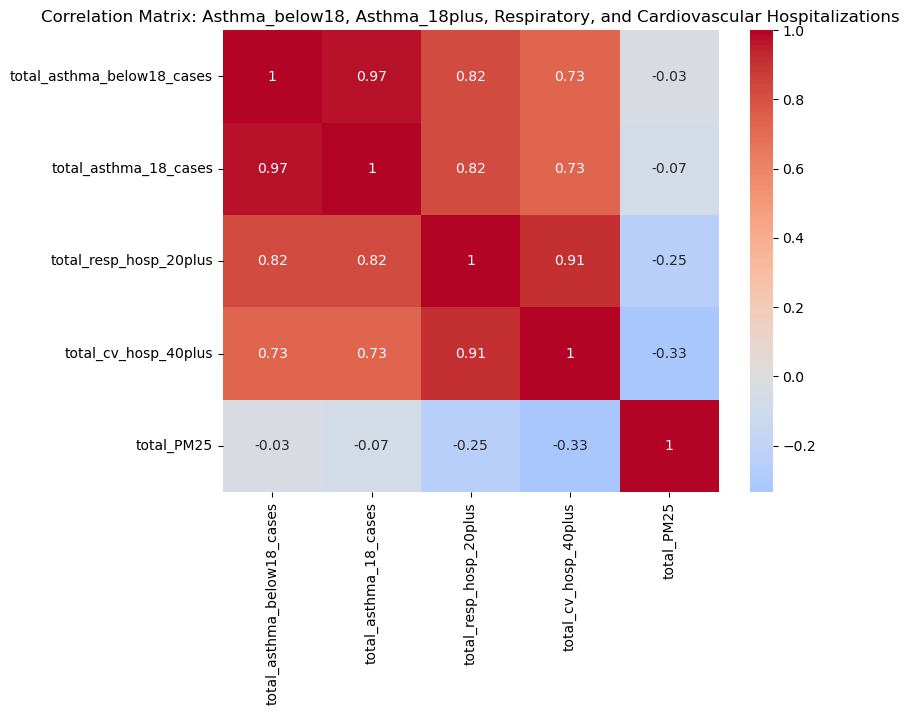

In [123]:
#Correlation analysis
# Calculate the correlation matrix
correlation_matrix = grouped_data[['total_asthma_below18_cases', 'total_asthma_18_cases', 'total_resp_hosp_20plus', 'total_cv_hosp_40plus','total_PM25']].corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Set the title
plt.title('Correlation Matrix: Asthma_below18, Asthma_18plus, Respiratory, and Cardiovascular Hospitalizations')

# Show the plot
plt.show()

In [124]:
# Check the number of non-NaN rows for each dependent variable
print(final_merged_with_pm25[['PM2.5', 'asthma_cases_under18', 'asthma_cases_18+', 'resp_hosp_20plus', 'cv_hosp_40plus']].notna().sum())

# Drop rows only where 'PM2.5' or any dependent variable of interest is NaN
final_merged_with_pm25_clean = final_merged_with_pm25.dropna(subset=['PM2.5'])

# Fill in missing health outcomes with a placeholder value (like 0 or median)
final_merged_with_pm25_clean['asthma_cases_under18'].fillna(0, inplace=True)
final_merged_with_pm25_clean['asthma_cases_18+'].fillna(0, inplace=True)
final_merged_with_pm25_clean['resp_hosp_20plus'].fillna(final_merged_with_pm25_clean['resp_hosp_20plus'].median(), inplace=True)
final_merged_with_pm25_clean['cv_hosp_40plus'].fillna(final_merged_with_pm25_clean['cv_hosp_40plus'].median(), inplace=True)

# Check descriptive statistics
print(final_merged_with_pm25_clean.describe())

PM2.5                   1152
asthma_cases_under18     450
asthma_cases_18+         450
resp_hosp_20plus         900
cv_hosp_40plus           900
dtype: int64
        Start_Year  asthma_cases_under18  asthma_cases_18+  resp_hosp_20plus  \
count  1152.000000           1152.000000       1152.000000       1152.000000   
mean   2013.250000             29.371615         14.189844         10.569792   
std       3.032405             50.320333         25.327168          4.229895   
min    2009.000000              0.000000          0.000000          2.000000   
25%    2011.250000              0.000000          0.000000          8.275000   
50%    2013.500000              0.000000          0.000000         10.000000   
75%    2015.500000             45.625000         19.375000         11.925000   
max    2017.000000            253.100000        130.600000         26.500000   

       cv_hosp_40plus        PM2.5  
count     1152.000000  1152.000000  
mean        13.367188     9.528776  
std       

### Regression analysis - with separate asthma cases

In [125]:
# Define the independent variable (PM2.5) and dependent variables (health outcomes)
X = final_merged_with_pm25_clean['PM2.5']
y_asthma_below18 = final_merged_with_pm25_clean['asthma_cases_under18']
y_asthma_18plus = final_merged_with_pm25_clean['asthma_cases_18+']
y_resp_hosp = final_merged_with_pm25_clean['resp_hosp_20plus']
y_cv_hosp = final_merged_with_pm25_clean['cv_hosp_40plus']

# Add a constant to the independent variable for the intercept in the model
X = sm.add_constant(X)

# Perform regression for each dependent variable
model_asthma_below18 = sm.OLS(y_asthma_below18, X).fit()
model_asthma_18plus = sm.OLS(y_asthma_18plus, X).fit()
model_resp_hosp = sm.OLS(y_resp_hosp, X).fit()
model_cv_hosp = sm.OLS(y_cv_hosp, X).fit()

# Print the summaries of the models
print("Regression results for Asthma Cases under 18:")
print(model_asthma_below18.summary())

print("\nRegression results for Asthma Cases above 18:")
print(model_asthma_18plus.summary())

print("\nRegression results for Respiratory Hospitalizations (20+):")
print(model_resp_hosp.summary())

print("\nRegression results for Cardiovascular Hospitalizations (40+):")
print(model_cv_hosp.summary())

Regression results for Asthma Cases under 18:
                             OLS Regression Results                             
Dep. Variable:     asthma_cases_under18   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.001
Method:                   Least Squares   F-statistic:                    0.3482
Date:                  Sun, 08 Dec 2024   Prob (F-statistic):              0.555
Time:                          14:43:07   Log-Likelihood:                -6148.0
No. Observations:                  1152   AIC:                         1.230e+04
Df Residuals:                      1150   BIC:                         1.231e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

### Regression analysis - combines asthma cases

In [126]:
# Combine asthma cases under 18 and 18+ by summing them
final_merged_with_pm25_clean['total_asthma_cases'] = final_merged_with_pm25_clean['asthma_cases_under18'] + final_merged_with_pm25_clean['asthma_cases_18+']

# Define the independent variable and the new dependent variable (total asthma cases)
X = final_merged_with_pm25_clean['PM2.5']
y_total_asthma = final_merged_with_pm25_clean['total_asthma_cases']

# Add a constant to the independent variable for the intercept in the model
X = sm.add_constant(X)

# Run the regression for the combined asthma cases
model_total_asthma = sm.OLS(y_total_asthma, X).fit()

#Print regression results
print("Regression results for Total Asthma Cases:")
print(model_total_asthma.summary())

Regression results for Total Asthma Cases:
                            OLS Regression Results                            
Dep. Variable:     total_asthma_cases   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.814
Date:                Sun, 08 Dec 2024   Prob (F-statistic):              0.178
Time:                        14:43:08   Log-Likelihood:                -6101.6
No. Observations:                1152   AIC:                         1.221e+04
Df Residuals:                    1150   BIC:                         1.222e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    